Paso este archivo con una recopilacion de lo que estuve haciendo referido al filtrado de las señales

Del archivo funciones, son utiles para revisar:

    extraer
    ordenar
    normalizar
    crear_butterworth
    filtrar_butterworth
    contar_etiquetas
    dividir_datos
    class MLP

In [6]:
import scipy.io
import matplotlib.pyplot as plt
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
import math
import datetime
import csv
from sklearn.utils import shuffle
from scipy.signal import butter, filtfilt, decimate, freqz
import funciones as mifu            # este es el archivo de funciones que pasé

# Filtrado, sin downsampling

Esta seccion es para visualizar el efecto de los filtros en la señal mediante graficos, no tiene más utilidad.

In [ ]:
sujeto = random.randint(1, 15)                                      # Selecciono un sujeto al azar
datos = mifu.extraer(sujeto)                                        # Extrae los valores del .mat
datos_ordenados = mifu.ordenar(datos)                               # Ordena los datos y etiquetas
medicion = random.randint(0, datos_ordenados[0].shape[0] - 1)       # Elije una de las N medidas al azar
canal = random.randint(0, 5)                                        # Elije un canal al azar (para graficar)

############################################################################################################################################################
# Grafico los 6 canales concatenados de la medida elegida, tal cual salen de la funcion "ordenar", solo para observarlos

plt.style.use('dark_background')
plt.figure(figsize=(16, 3))
for i in range(6):
    plt.axvspan(i*4096, (i + 1)*4096, color = 'white', alpha = 0.15 - (0.03*i))
    x_pos = (i*4096 + (i + 1)*4096) / 2
    y_pos = 1.05*np.max(datos_ordenados[0][medicion])
    plt.text(x_pos, y_pos, 'Canal ' + str(i + 1), fontsize = 10, ha = 'center', va = 'top', color = 'white')
plt.plot(datos_ordenados[0][medicion], color = 'dodgerblue')
plt.title("Valores de EEG, sujeto " + str(sujeto) + ', medición N° ' + str(medicion + 1))
plt.xlabel("Sample")
plt.ylabel("Magnitud")
plt.xlim(-100, 24676)
plt.show()

############################################################################################################################################################
# Transformada de fourier rapida para ver el espacio de frecuencias, y poder luego contrastar el antes y despues del filtrado
fs = 1024
magnitudes_fft_sin_filtrar = np.abs(np.fft.fft(datos_ordenados[0][medicion][canal*4096:(canal + 1)*4096])) # Me quedo con el modulo de los coeficientes
frecuencias_sin_filtrar = np.fft.fftfreq(len(datos_ordenados[0][medicion][canal*4096:(canal + 1)*4096]), d = 1/fs)
magnitudes_fft_sin_filtrar = magnitudes_fft_sin_filtrar[:len(frecuencias_sin_filtrar)//2]
frecuencias_sin_filtrar = frecuencias_sin_filtrar[:len(frecuencias_sin_filtrar)//2]
# Aca estoy analizando el espectro de frecuencias de los datos de una sola de las N mediciones, para solo un canal de entre los 6, y sin haber filtrado nada

############################################################################################################################################################

# Filtro pasa-bajos (el que usaria para detectar parpadeos)
corte_bajo1 = 9      # da igual, es pasa-bajos, no lo va a usar
corte_alto1 = 8
orden1 = 4
tipo1 = 'low'  ###
datos_filtrados1 = mifu.filtrar_butterworth(datos_ordenados, tipo1, corte_bajo1, corte_alto1, fs, orden1)
magnitudes_fft_filtrado1 = np.abs(np.fft.fft(datos_filtrados1[0][medicion][canal*4096:(canal + 1)*4096]))
frecuencias_filtrado1 = np.fft.fftfreq(len(datos_filtrados1[0][medicion][canal*4096:(canal + 1)*4096]), d = 1/fs)
magnitudes_fft_filtrado1 = magnitudes_fft_filtrado1[:len(frecuencias_sin_filtrar)//2]
frecuencias_filtrado1 = frecuencias_filtrado1[:len(frecuencias_sin_filtrar)//2]

# Filtro pasa-banda (el que usaria para predecir estimulo)
corte_bajo2 = 8
corte_alto2 = 30
orden2 = 4
tipo2 = 'band'  ###
datos_filtrados2 = mifu.filtrar_butterworth(datos_ordenados, tipo2, corte_bajo2, corte_alto2, fs, orden2)
magnitudes_fft_filtrado2 = np.abs(np.fft.fft(datos_filtrados2[0][medicion][canal*4096:(canal + 1)*4096]))
frecuencias_filtrado2 = np.fft.fftfreq(len(datos_filtrados2[0][medicion][canal*4096:(canal + 1)*4096]), d = 1/fs)
magnitudes_fft_filtrado2 = magnitudes_fft_filtrado2[:len(frecuencias_sin_filtrar)//2]
frecuencias_filtrado2 = frecuencias_filtrado2[:len(frecuencias_sin_filtrar)//2]

############################################################################################################################################################
# Esto sirve para imprimir un cuadro que muestre las etiquetas en los graficos, meramente estetico
indice = (datos_filtrados1[1][medicion] - 1).astype(int)
ref_etiq = [['Imaginada', 'Pronunciada'][indice[0]], ['A', 'E', 'I', 'O', 'U', 'Arriba', 'Abajo', 'Adelante', 'Atras', 'Derecha', 'Izquierda'][indice[1]], ['Sin parpadeo', 'Con parpadeo'][indice[2]]]
ref_etiq = str(ref_etiq[0]) + ' - ' + str(ref_etiq[1]) + ' - ' + str(ref_etiq[2])

###########################################################################################
# Grafico los espectros de frecuencia de la señal sin filtrar y la que pasa por el filtro 1
plt.figure(figsize=(16, 3))

ondas_cerebrales = [
    {"nombre": "Delta", "inicio": 0, "fin": 4, 'tr': 0.15},                                       ###
    {"nombre": "Theta", "inicio": 4, "fin": 8, 'tr': 0.12},                                        ##
    {"nombre": "Alpha", "inicio": 8, "fin": 13, 'tr': 0.09},                                       ##
    {"nombre": "Beta", "inicio": 13, "fin": 30, 'tr': 0.06},                                       ##
    {"nombre": "Gamma", "inicio": 30, "fin": 64, 'tr': 0.03}                                       ##
]                                                                                                  ## Esto cambia el color del fondo para distinguir bandas
for onda in ondas_cerebrales:                                                                      ##
    plt.axvspan(onda["inicio"], onda["fin"], color = 'white', alpha = onda['tr'])                  ##
    x_pos = (onda["inicio"] + onda["fin"]) / 2                                                     ##
    y_pos = 1.05*max(magnitudes_fft_sin_filtrar)                                                   ##
    plt.text(x_pos, y_pos, onda["nombre"], fontsize=10, ha='center', va='top', color='white')     ###

plt.plot(frecuencias_sin_filtrar, magnitudes_fft_sin_filtrar, label = 'Sin filtrar', color = 'dodgerblue')
plt.xlim(0, 64)
plt.title("Espectro de Frecuencia de EEG, sujeto " + str(sujeto) + ', medición N° ' + str(medicion + 1) + ', canal ' + str(canal + 1))
plt.xlabel("Frecuencia (Hz)")
plt.ylabel("Magnitud")
plt.ylim(0, max(magnitudes_fft_sin_filtrar)*1.1)
if tipo1 == 'band':
    texto1 = 'Filtro pasa-banda ' + str(corte_bajo1) + '-' + str(corte_alto1) + ' Hz, orden ' + str(orden1)
    plt.axvline(corte_bajo1, color='white', linestyle='--', label=f'{corte_bajo1} Hz (Corte inferior)')
    plt.axvline(corte_alto1, color='white', linestyle='--', label=f'{corte_alto1} Hz (Corte superior)')
    plt.plot(frecuencias_filtrado1, magnitudes_fft_filtrado1, label = texto1, color = 'orange')
elif tipo1 == 'low':
    texto1 = 'Filtro pasa bajos ' + str(corte_alto1) + ' Hz, orden ' + str(orden1)
    plt.axvline(corte_alto1, color='white', linestyle='--', label=f'{corte_alto1} Hz (Corte superior)')
    plt.plot(frecuencias_filtrado1, magnitudes_fft_filtrado1, label = texto1, color = 'orange')
elif tipo1 == 'high':
    texto1 = 'Filtro pasa altos ' + str(corte_bajo1) + ' Hz, orden ' + str(orden1)
    plt.axvline(corte_bajo1, color='white', linestyle='--', label=f'{corte_bajo1} Hz (Corte inferior)')
    plt.plot(frecuencias_filtrado1, magnitudes_fft_filtrado1, label = texto1, color = 'orange')
plt.text(40, max(magnitudes_fft_sin_filtrar)*0.8, ref_etiq, fontsize=10, bbox = dict(facecolor='black', alpha = 1.0))
plt.grid(linewidth = 0.2)
plt.legend()
plt.show()

# Grafico valores
plt.style.use('dark_background')
plt.figure(figsize=(16, 3))
plt.plot(datos_ordenados[0][medicion][canal*4096:(canal + 1)*4096], label = 'Sin filtrar', color = 'dodgerblue')
plt.plot(datos_filtrados1[0][medicion][canal*4096:(canal + 1)*4096], label = texto1, color = 'orange')
plt.title("Valores de EEG, sujeto " + str(sujeto) + ', medición N° ' + str(medicion + 1) + ', canal ' + str(canal + 1))
plt.xlabel("Sample")
plt.ylabel("Magnitud")
plt.text(4200, 1.3*max(np.max(datos_ordenados[0][medicion][canal*4096:(canal + 1)*4096]), np.max(datos_filtrados1[0][medicion][canal*4096:(canal + 1)*4096])), ref_etiq, fontsize=10, ha='right', va='top', bbox = dict(facecolor='black', alpha = 1.0))
plt.grid(linewidth = 0.2)
plt.legend()
plt.show()

###########################################################################################
# Grafico los espectros de frecuencia de la señal sin filtrar y la que pasa por el filtro 2
plt.figure(figsize=(16, 3))
plt.style.use('dark_background')

ondas_cerebrales = [
    {"nombre": "Delta", "inicio": 0, "fin": 4, 'tr': 0.15},                                       ###
    {"nombre": "Theta", "inicio": 4, "fin": 8, 'tr': 0.12},                                        ##
    {"nombre": "Alpha", "inicio": 8, "fin": 13, 'tr': 0.09},                                       ##
    {"nombre": "Beta", "inicio": 13, "fin": 30, 'tr': 0.06},                                       ##
    {"nombre": "Gamma", "inicio": 30, "fin": 64, 'tr': 0.03}                                       ##
]                                                                                                  ## Esto cambia el color del fondo para distinguir bandas
for onda in ondas_cerebrales:                                                                      ##
    plt.axvspan(onda["inicio"], onda["fin"], color = 'white', alpha = onda['tr'])                  ##
    x_pos = (onda["inicio"] + onda["fin"]) / 2                                                     ##
    y_pos = 1.05*max(magnitudes_fft_sin_filtrar)                                                   ##
    plt.text(x_pos, y_pos, onda["nombre"], fontsize=10, ha='center', va='top', color='white')     ###

plt.plot(frecuencias_sin_filtrar, magnitudes_fft_sin_filtrar, label = 'Sin filtrar', color = 'dodgerblue')
plt.xlim(0, 64)
plt.title("Espectro de Frecuencia de EEG, sujeto " + str(sujeto) + ', medición N° ' + str(medicion + 1) + ', canal ' + str(canal + 1))
plt.xlabel("Frecuencia (Hz)")
plt.ylabel("Magnitud")
plt.ylim(0, max(magnitudes_fft_sin_filtrar)*1.1)
if tipo2 == 'band':
    texto2 = 'Filtro pasa-banda ' + str(corte_bajo2) + '-' + str(corte_alto2) + ' Hz, orden ' + str(orden2)
    plt.axvline(corte_bajo2, color='white', linestyle='--', label=f'{corte_bajo2} Hz (Corte inferior)')
    plt.axvline(corte_alto2, color='white', linestyle='--', label=f'{corte_alto2} Hz (Corte superior)')
    plt.plot(frecuencias_filtrado2, magnitudes_fft_filtrado2, label = texto2, color = 'orange')
elif tipo2 == 'low':
    texto2 = 'Filtro pasa bajos ' + str(corte_alto2) + ' Hz, orden ' + str(orden2)
    plt.axvline(corte_alto2, color='white', linestyle='--', label=f'{corte_alto2} Hz (Corte superior)')
    plt.plot(frecuencias_filtrado2, magnitudes_fft_filtrado2, label = texto2, color = 'orange')
elif tipo2 == 'high':
    texto2 = 'Filtro pasa altos ' + str(corte_bajo2) + ' Hz, orden ' + str(orden2)
    plt.axvline(corte_bajo2, color='white', linestyle='--', label=f'{corte_bajo2} Hz (Corte inferior)')
    plt.plot(frecuencias_filtrado2, magnitudes_fft_filtrado2, label = texto2, color = 'orange')
plt.text(40, max(magnitudes_fft_sin_filtrar)*0.8, ref_etiq, fontsize=10, bbox = dict(facecolor='black', alpha = 1.0))
plt.grid(linewidth = 0.2)
plt.legend()
plt.show()

# Grafico valores
plt.figure(figsize=(16, 3))
plt.style.use('dark_background')
plt.plot(datos_ordenados[0][medicion][canal*4096:(canal + 1)*4096], label = 'Sin filtrar', color = 'dodgerblue')
plt.plot(datos_filtrados2[0][medicion][canal*4096:(canal + 1)*4096], label = texto2, color = 'orange')
plt.title("Valores de EEG, sujeto " + str(sujeto) + ', medición N° ' + str(medicion + 1) + ', canal ' + str(canal + 1))
plt.xlabel("Sample")
plt.ylabel("Magnitud")
plt.text(4200, 1.3*max(np.max(datos_ordenados[0][medicion][canal*4096:(canal + 1)*4096]), np.max(datos_filtrados2[0][medicion][canal*4096:(canal + 1)*4096])), ref_etiq, fontsize=10, ha='right', va='top', bbox = dict(facecolor='black', alpha = 1.0))
plt.grid(linewidth = 0.2)
plt.legend()
plt.show()

Ahora si, vamos a probar modelos

In [63]:
sujeto = random.randint(1, 15)
prediccion = 'estimulo'         # Al querer predecir estimulo, uso el filtro pasa-banda
datos = mifu.extraer(sujeto)
datos_ordenados = mifu.ordenar(datos)

# Filtro
corte_bajo = 8
corte_alto = 30
orden = 4
tipo = 'band'
fs = 1024
datos_filtrados = mifu.filtrar_butterworth(datos_ordenados, tipo, corte_bajo, corte_alto, fs, orden)

fraccion_entrenamiento = 0.25
semilla = random.randint(0, 999999) # Me sirve para que ambas divisiones se den con los mismos datos

# Normalizo ambos datos
datos_normalizados_sin_filtrar = mifu.normalizar(datos_ordenados)
datos_normalizados_filtrados = mifu.normalizar(datos_filtrados)

# Divido ambos datos entre set de entrenamiento y prueba
datos_divididos_sin_filtrar = mifu.dividir_datos(datos_normalizados_sin_filtrar, fraccion_entrenamiento, prediccion, semilla)
datos_divididos_filtrados = mifu.dividir_datos(datos_normalizados_filtrados, fraccion_entrenamiento, prediccion, semilla)

neuronas_entrada = datos_divididos_filtrados[0][0].shape[1]
ocultas = [256, 256]    # Fue la combinacion que mejor funciono antes
neuronas_salida = 11
epocas = 1000
plotear = 0     # Si es 1 grafica la perdida, si es 0 no lo hace
tol = 1e-5
ls = 0.0001

# Mezclo los conjuntos y etiquetas de entrenamiento, para que el programa se entrene exponiendose de forma aleatoria a las distintas etiquetas, y no un tipo
# detras del otro en orden, sospechando que eso podria causar problemas en el entrenamiento.
# Si esto ultimo no se entendió, descomentar y correr la siguiente linea:
# print(datos_divididos_sin_filtrar[0][1], datos_divididos_filtrados[0][1])

datos_divididos_sin_filtrar[0][0], datos_divididos_sin_filtrar[0][1], datos_divididos_filtrados[0][0], datos_divididos_filtrados[0][1] = shuffle(datos_divididos_sin_filtrar[0][0], datos_divididos_sin_filtrar[0][1], datos_divididos_filtrados[0][0], datos_divididos_filtrados[0][1], random_state = semilla)

# Defino y entreno los modelos
modelo_sin_filtrar = mifu.MLP(neuronas_entrada, ocultas, neuronas_salida)
mifu.MLP.entrenar(modelo_sin_filtrar, epocas, datos_divididos_sin_filtrar[0][0], datos_divididos_sin_filtrar[0][1], plotear, tol, ls)
modelo_filtrado = mifu.MLP(neuronas_entrada, ocultas, neuronas_salida)
mifu.MLP.entrenar(modelo_filtrado, epocas, datos_divididos_filtrados[0][0], datos_divididos_filtrados[0][1], plotear, tol, ls)

# Evaluo ambos
precision_sin_filtrar, predicciones_sin_filtrar = mifu.MLP.evaluar(modelo_sin_filtrar, datos_divididos_sin_filtrar[1][0], datos_divididos_sin_filtrar[1][1])
precision_filtrados, predicciones_filtrados = mifu.MLP.evaluar(modelo_filtrado, datos_divididos_filtrados[1][0], datos_divididos_filtrados[1][1])
print(np.bincount(predicciones_sin_filtrar), np.bincount(datos_divididos_sin_filtrar[1][1]))
print(np.bincount(predicciones_filtrados), np.bincount(datos_divididos_filtrados[1][1]))

# Si queres ver que predijo vs que debia predecir:
# print(predicciones_sin_filtrar, datos_divididos_sin_filtrar[1][1])
# print(predicciones_filtrados, datos_divididos_filtrados[1][1])

Se usara el 23% para entrenar al modelo.
Se usara el 23% para entrenar al modelo.
La precision del modelo es del 12.82609%.
La precision del modelo es del 9.13043%.
[43 34 42 33 44 53 44 39 52 38 38] [39 42 42 39 39 41 43 42 45 43 45]
[23 62 32 28 44 36 47 36 52 47 53] [39 42 42 39 39 41 43 42 45 43 45]


In [34]:
# Algunos resultados que fui sacando, el orden es siempre:
# sin filtrar
# filtrado

# La precision del modelo es del 9.95575%.
# La precision del modelo es del 9.73451%.
# [169   1   0   1   0   0 227  49   5] [43 43 42 40 44 42 36 42 40 40 40]
# [66  2 38 70 59 62 11 17 56 54 17] [43 43 42 40 44 42 36 42 40 40 40]

# La precision del modelo es del 12.5%.
# La precision del modelo es del 10.77586%.
# [66 42 34 49 46 52 22 33 30 53 37] [44 43 45 38 43 44 42 42 41 43 39]
# [41 41 42 58 44 41 20 32 38 64 43] [44 43 45 38 43 44 42 42 41 43 39]

# La precision del modelo es del 11.85345%.
# La precision del modelo es del 12.71552%.
# [33 49 45 39 85 21 39 31 31 45 46] [44 43 45 38 43 44 42 42 41 43 39]
# [40 41 39 33 68 32 29 51 51 34 46] [44 43 45 38 43 44 42 42 41 43 39]

# La precision del modelo es del 11.36842%.
# La precision del modelo es del 10.10526%.
# [40 52 39 49 28 18 61 67 37 50 34] [43 43 38 42 44 45 40 46 46 46 42]
# [44 53 44 55 40 37 36 35 37 45 49] [43 43 38 42 44 45 40 46 46 46 42]

# La precision del modelo es del 12.85141%.
# La precision del modelo es del 11.24498%.
# [22 56 40 59 72 49 44 35 49 38 34] [42 43 44 45 42 46 48 48 46 48 46]
# [66 65 21 44 37 40 46 52 39 52 36] [42 43 44 45 42 46 48 48 46 48 46]

# La precision del modelo es del 12.10191%.
# La precision del modelo es del 10.19108%.
# [37 54 44 63 39 39 49 30 32 51 33] [43 42 42 42 42 43 44 43 44 42 44]
# [52 45 48 82 50 37 21 21 36 35 44] [43 42 42 42 42 43 44 43 44 42 44]

# La precision del modelo es del 13.0531%.
# La precision del modelo es del 10.84071%.
# [59 35 23 34 23 42 52 41 53 38 52] [44 36 38 39 40 41 43 42 44 42 43]
# [34 30 43 35 43 40 31 54 31 40 71] [44 36 38 39 40 41 43 42 44 42 43]

# La precision del modelo es del 12.54682%.
# La precision del modelo es del 10.29963%.
# [35 54 55 49 45 68 29 26 29 80 64] [56 49 53 52 51 48 47 44 46 44 44]
# [56 54 57 61 65 45 53 22 28 62 31] [56 49 53 52 51 48 47 44 46 44 44]

# La precision del modelo es del 12.82609%.
# La precision del modelo es del 9.13043%.
# [43 34 42 33 44 53 44 39 52 38 38] [39 42 42 39 39 41 43 42 45 43 45]
# [23 62 32 28 44 36 47 36 52 47 53] [39 42 42 39 39 41 43 42 45 43 45]

# Misma comparación, pero usando downsampling a 128 Hz

Primero la parte grafica, para ver que pasa nada mas

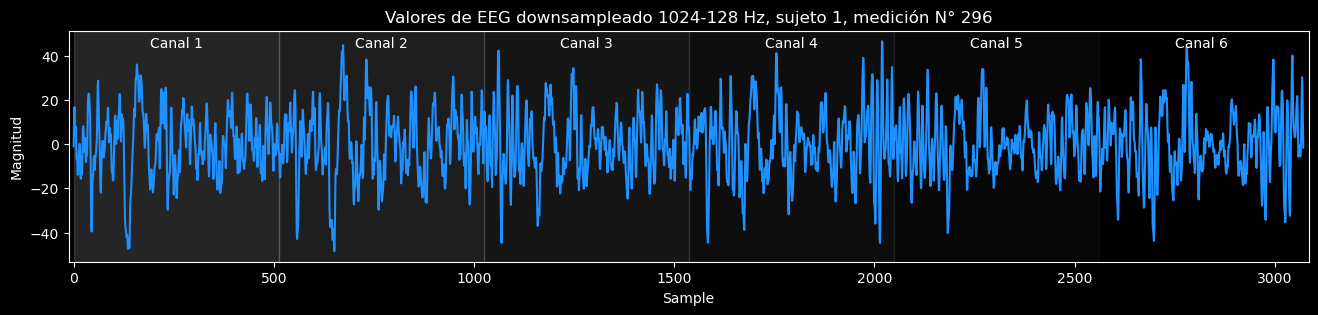

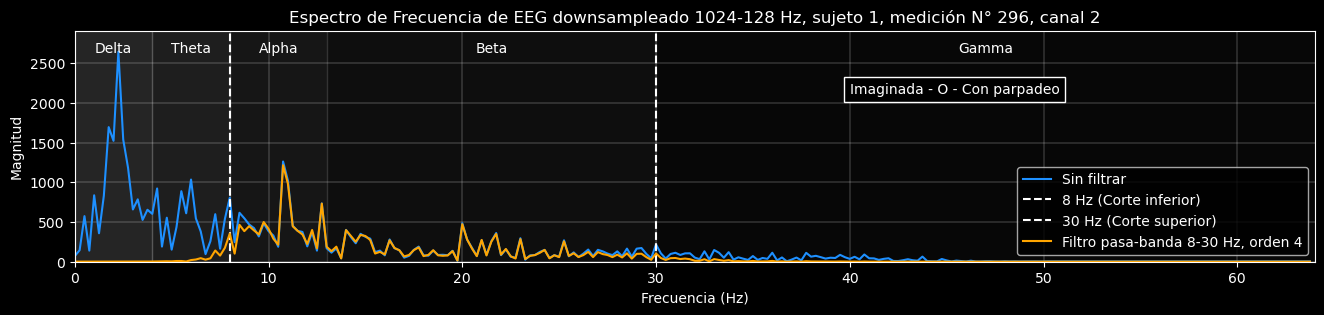

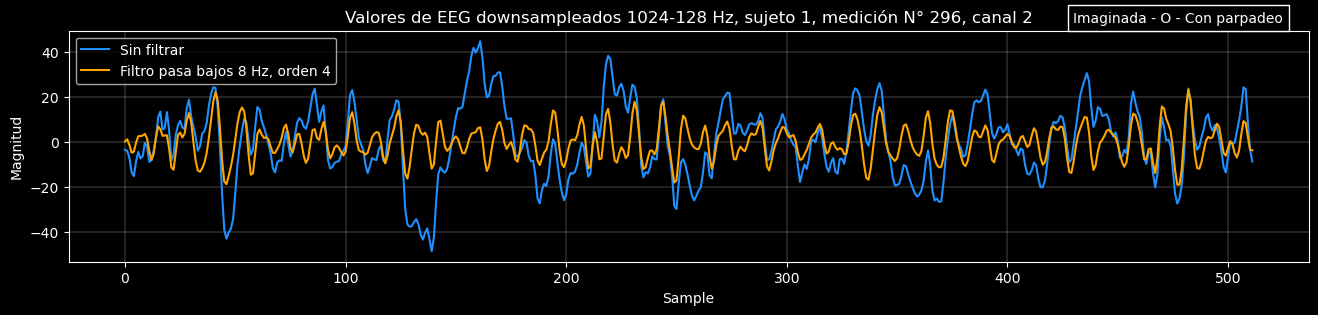

In [65]:
sujeto = random.randint(1, 15)                                      # Selecciono un sujeto al azar
datos = mifu.extraer(sujeto)                                        # Extrae los valores del .mat
datos_ordenados = mifu.ordenar(datos)                               # Ordena los datos y etiquetas
medicion = random.randint(0, datos_ordenados[0].shape[0] - 1)       # Elije una de las N medidas al azar
canal = random.randint(0, 5)                                        # Elije un canal al azar (para graficar)

############################################################################################################################################################
# Filtro pasa-bandas
corte_bajo = 8
corte_alto = 30
orden = 4
tipo = 'band'
fs = 1024
datos_filtrados = mifu.filtrar_butterworth(datos_ordenados, tipo, corte_bajo, corte_alto, fs, orden)

############################################################################################################################################################
# Le hago un downsampling a los datos con y sin filtrar
fs_original = 1024
fs_nueva = 128
factor = fs_original // fs_nueva
datos_downsampleados = [np.empty((datos_ordenados[0].shape[0], fs_nueva*4*6)), datos_ordenados[1]]
datos_downsampleados_filtrados = [np.empty((datos_filtrados[0].shape[0], fs_nueva*4*6)), datos_filtrados[1]]

for i in range(6):  # Se hace por canal en cada una de las mediciones
    datos_downsampleados[0][:,fs_nueva*4*i:fs_nueva*4*(i + 1)] = decimate(datos_ordenados[0][:,4096*i:4096*(i + 1)], factor, axis = 1, zero_phase = True)
    datos_downsampleados_filtrados[0][:,fs_nueva*4*i:fs_nueva*4*(i + 1)] = decimate(datos_filtrados[0][:,4096*i:4096*(i + 1)], factor, axis = 1, zero_phase = True)

############################################################################################################################################################
# Grafico los 6 canales concatenados de la medida elegida, despues de ser downsampleados, solo para observarlos

plt.style.use('dark_background')
plt.figure(figsize=(16, 3))
for i in range(6):
    plt.axvspan(i*fs_nueva*4, (i + 1)*fs_nueva*4, color = 'white', alpha = 0.15 - (0.03*i))
    x_pos = (i*fs_nueva*4 + (i + 1)*fs_nueva*4) / 2
    y_pos = 1.05*np.max(datos_downsampleados[0][medicion])
    plt.text(x_pos, y_pos, 'Canal ' + str(i + 1), fontsize = 10, ha = 'center', va = 'top', color = 'white')
plt.plot(datos_downsampleados[0][medicion], color = 'dodgerblue')
plt.title("Valores de EEG downsampleado 1024-128 Hz, sujeto " + str(sujeto) + ', medición N° ' + str(medicion + 1))
plt.xlabel("Sample")
plt.ylabel("Magnitud")
plt.xlim(-100/factor, 24676/factor)
plt.show()

############################################################################################################################################################
# Transformada de fourier rapida para ver el espacio de frecuencias, y poder luego contrastar el con y sin filtrado

# Sin filtrar
magnitudes_fft_sin_filtrar = np.abs(np.fft.fft(datos_downsampleados[0][medicion][canal*4*fs_nueva:(canal + 1)*4*fs_nueva])) # Me quedo con el modulo de los coeficientes
frecuencias_sin_filtrar = np.fft.fftfreq(len(datos_downsampleados[0][medicion][canal*4*fs_nueva:(canal + 1)*4*fs_nueva]), d = 1/fs_nueva)
magnitudes_fft_sin_filtrar = magnitudes_fft_sin_filtrar[:len(frecuencias_sin_filtrar)//2]
frecuencias_sin_filtrar = frecuencias_sin_filtrar[:len(frecuencias_sin_filtrar)//2]

# Filtrado
magnitudes_fft_filtrado = np.abs(np.fft.fft(datos_downsampleados_filtrados[0][medicion][canal*4*fs_nueva:(canal + 1)*4*fs_nueva]))
frecuencias_filtrado = np.fft.fftfreq(len(datos_downsampleados_filtrados[0][medicion][canal*4*fs_nueva:(canal + 1)*4*fs_nueva]), d = 1/fs_nueva)
magnitudes_fft_filtrado = magnitudes_fft_filtrado[:len(frecuencias_filtrado)//2]
frecuencias_filtrado = frecuencias_filtrado[:len(frecuencias_filtrado)//2]

# Sin downsamplear
# magnitudes_fft = np.abs(np.fft.fft(datos_ordenados[0][medicion][canal*4*fs_original:(canal + 1)*4*fs_original]))
# frecuencias = np.fft.fftfreq(len(datos_ordenados[0][medicion][canal*4*fs_original:(canal + 1)*4*fs_original]), d = 1/fs_original)
# magnitudes_fft = magnitudes_fft[:len(frecuencias)//2]/factor
# frecuencias = frecuencias[:len(frecuencias)//2]

############################################################################################################################################################
# Esto sirve para imprimir un cuadro que muestre las etiquetas en los graficos, meramente estetico
indice = (datos_filtrados[1][medicion] - 1).astype(int)
ref_etiq = [['Imaginada', 'Pronunciada'][indice[0]], ['A', 'E', 'I', 'O', 'U', 'Arriba', 'Abajo', 'Adelante', 'Atras', 'Derecha', 'Izquierda'][indice[1]], ['Sin parpadeo', 'Con parpadeo'][indice[2]]]
ref_etiq = str(ref_etiq[0]) + ' - ' + str(ref_etiq[1]) + ' - ' + str(ref_etiq[2])

############################################################################################################################################################
# Grafico los espectros de frecuencia de la señal downsampleada con y sin filtrar
plt.figure(figsize=(16, 3))

ondas_cerebrales = [
    {"nombre": "Delta", "inicio": 0, "fin": 4, 'tr': 0.15},                                       ###
    {"nombre": "Theta", "inicio": 4, "fin": 8, 'tr': 0.12},                                        ##
    {"nombre": "Alpha", "inicio": 8, "fin": 13, 'tr': 0.09},                                       ##
    {"nombre": "Beta", "inicio": 13, "fin": 30, 'tr': 0.06},                                       ##
    {"nombre": "Gamma", "inicio": 30, "fin": 64, 'tr': 0.03}                                       ##
]                                                                                                  ## Esto cambia el color del fondo para distinguir bandas
for onda in ondas_cerebrales:                                                                      ##
    plt.axvspan(onda["inicio"], onda["fin"], color = 'white', alpha = onda['tr'])                  ##
    x_pos = (onda["inicio"] + onda["fin"]) / 2                                                     ##
    y_pos = 1.05*max(magnitudes_fft_sin_filtrar)                                                   ##
    plt.text(x_pos, y_pos, onda["nombre"], fontsize=10, ha='center', va='top', color='white')     ###

plt.plot(frecuencias_sin_filtrar, magnitudes_fft_sin_filtrar, label = 'Sin filtrar', color = 'dodgerblue')
# plt.plot(frecuencias, magnitudes_fft, label = 'Sin downsamplear', color = 'lightcoral')
plt.xlim(0, 64)
plt.title("Espectro de Frecuencia de EEG downsampleado 1024-128 Hz, sujeto " + str(sujeto) + ', medición N° ' + str(medicion + 1) + ', canal ' + str(canal + 1))
plt.xlabel("Frecuencia (Hz)")
plt.ylabel("Magnitud")
plt.ylim(0, max(magnitudes_fft_sin_filtrar)*1.1)
if tipo == 'band':
    texto = 'Filtro pasa-banda ' + str(corte_bajo) + '-' + str(corte_alto) + ' Hz, orden ' + str(orden)
    plt.axvline(corte_bajo, color='white', linestyle='--', label = f'{corte_bajo} Hz (Corte inferior)')
    plt.axvline(corte_alto, color='white', linestyle='--', label = f'{corte_alto} Hz (Corte superior)')
    plt.plot(frecuencias_filtrado, magnitudes_fft_filtrado, label = texto, color = 'orange')
elif tipo == 'low':
    texto1 = 'Filtro pasa bajos ' + str(corte_alto1) + ' Hz, orden ' + str(orden)
    plt.axvline(corte_alto, color='white', linestyle='--', label = f'{corte_alto} Hz (Corte superior)')
    plt.plot(frecuencias_filtrado1, magnitudes_fft_filtrado1, label = texto1, color = 'orange')
elif tipo == 'high':
    texto = 'Filtro pasa altos ' + str(corte_bajo) + ' Hz, orden ' + str(orden)
    plt.axvline(corte_bajo, color='white', linestyle='--', label = f'{corte_bajo} Hz (Corte inferior)')
    plt.plot(frecuencias_filtrado, magnitudes_fft_filtrado, label = texto, color = 'orange')
plt.text(40, max(magnitudes_fft_sin_filtrar)*0.8, ref_etiq, fontsize=10, bbox = dict(facecolor = 'black', alpha = 1.0))
plt.grid(linewidth = 0.2)
plt.legend()
plt.show()

# Grafico valores
plt.figure(figsize=(16, 3))
plt.plot(datos_downsampleados[0][medicion][canal*4*fs_nueva:(canal + 1)*4*fs_nueva], label = 'Sin filtrar', color = 'dodgerblue')
plt.plot(datos_downsampleados_filtrados[0][medicion][canal*4*fs_nueva:(canal + 1)*4*fs_nueva], label = texto1, color = 'orange')
plt.title("Valores de EEG downsampleados 1024-128 Hz, sujeto " + str(sujeto) + ', medición N° ' + str(medicion + 1) + ', canal ' + str(canal + 1))
plt.xlabel("Sample")
plt.ylabel("Magnitud")
plt.text(4200/factor, 1.3*max(np.max(datos_downsampleados[0][medicion][canal*4*fs_nueva:(canal + 1)*4*fs_nueva]), np.max(datos_downsampleados_filtrados[0][medicion][canal*4*fs_nueva:(canal + 1)*4*fs_nueva])), ref_etiq, fontsize = 10, ha = 'right', va = 'top', bbox = dict(facecolor = 'black', alpha = 1.0))
plt.grid(linewidth = 0.2)
plt.legend()
plt.show()

Y a probar los modelos otra vez

In [77]:
sujeto = random.randint(1, 15)
prediccion = 'estimulo'         # Al querer predecir estimulo, uso el filtro pasa-banda
datos = mifu.extraer(sujeto)
datos_ordenados = mifu.ordenar(datos)

# Filtro
corte_bajo = 8
corte_alto = 30
orden = 4
tipo = 'band'
fs = 1024
datos_filtrados = mifu.filtrar_butterworth(datos_ordenados, tipo, corte_bajo, corte_alto, fs, orden)

# Le hago un downsampling a los datos con y sin filtrar
fs_original = 1024
fs_nueva = 128
factor = fs_original // fs_nueva
datos_downsampleados = [np.empty((datos_ordenados[0].shape[0], fs_nueva*4*6)), datos_ordenados[1]]
datos_downsampleados_filtrados = [np.empty((datos_filtrados[0].shape[0], fs_nueva*4*6)), datos_filtrados[1]]

for i in range(6):  # Se hace por canal en cada una de las mediciones
    datos_downsampleados[0][:,fs_nueva*4*i:fs_nueva*4*(i + 1)] = decimate(datos_ordenados[0][:,4096*i:4096*(i + 1)], factor, axis = 1, zero_phase = True)
    datos_downsampleados_filtrados[0][:,fs_nueva*4*i:fs_nueva*4*(i + 1)] = decimate(datos_filtrados[0][:,4096*i:4096*(i + 1)], factor, axis = 1, zero_phase = True)

# Normalizo ambos datos
datos_normalizados_sin_filtrar = mifu.normalizar(datos_downsampleados)
datos_normalizados_filtrados = mifu.normalizar(datos_downsampleados_filtrados)

fraccion_entrenamiento = 0.25
semilla = random.randint(0, 999999) # Me sirve para que ambas divisiones se den con los mismos datos

# Divido ambos datos entre set de entrenamiento y prueba
datos_divididos_sin_filtrar = mifu.dividir_datos(datos_normalizados_sin_filtrar, fraccion_entrenamiento, prediccion, semilla)
datos_divididos_filtrados = mifu.dividir_datos(datos_normalizados_filtrados, fraccion_entrenamiento, prediccion, semilla)

neuronas_entrada = datos_divididos_filtrados[0][0].shape[1]
ocultas = [256, 256]    # Quiza ahora podria reducir esta cantidad de neuronas tambien, no lo probe
neuronas_salida = 11
epocas = 3000       # Al tener menos neuronas en la capa de entrada, puedo ponerle mas tiempo de entrenamiento
plotear = 0         # Si es 1 grafica la perdida, si es 0 no lo hace
tol = 1e-5
ls = 0.0001

# Mezclo los conjuntos y etiquetas de entrenamiento, para que el programa se entrene exponiendose de forma aleatoria a las distintas etiquetas, y no un tipo
# detras del otro en orden, sospechando que eso podria causar problemas en el entrenamiento.
# Si esto ultimo no se entendió, descomentar y correr la siguiente linea:
# print(datos_divididos_sin_filtrar[0][1], datos_divididos_filtrados[0][1])

datos_divididos_sin_filtrar[0][0], datos_divididos_sin_filtrar[0][1], datos_divididos_filtrados[0][0], datos_divididos_filtrados[0][1] = shuffle(datos_divididos_sin_filtrar[0][0], datos_divididos_sin_filtrar[0][1], datos_divididos_filtrados[0][0], datos_divididos_filtrados[0][1], random_state = semilla)

# Defino y entreno los modelos
modelo_sin_filtrar = mifu.MLP(neuronas_entrada, ocultas, neuronas_salida)
mifu.MLP.entrenar(modelo_sin_filtrar, epocas, datos_divididos_sin_filtrar[0][0], datos_divididos_sin_filtrar[0][1], plotear, tol, ls)
modelo_filtrado = mifu.MLP(neuronas_entrada, ocultas, neuronas_salida)
mifu.MLP.entrenar(modelo_filtrado, epocas, datos_divididos_filtrados[0][0], datos_divididos_filtrados[0][1], plotear, tol, ls)

# Evaluo ambos
precision_sin_filtrar, predicciones_sin_filtrar = mifu.MLP.evaluar(modelo_sin_filtrar, datos_divididos_sin_filtrar[1][0], datos_divididos_sin_filtrar[1][1])
precision_filtrados, predicciones_filtrados = mifu.MLP.evaluar(modelo_filtrado, datos_divididos_filtrados[1][0], datos_divididos_filtrados[1][1])
print(np.bincount(predicciones_sin_filtrar), np.bincount(datos_divididos_sin_filtrar[1][1]))
print(np.bincount(predicciones_filtrados), np.bincount(datos_divididos_filtrados[1][1]))

# Si queres ver que predijo vs que debia predecir:
# print(predicciones_sin_filtrar, datos_divididos_sin_filtrar[1][1])
# print(predicciones_filtrados, datos_divididos_filtrados[1][1])

Se usara el 21% para entrenar al modelo.
Se usara el 21% para entrenar al modelo.
La precision del modelo es del 9.95575%.
La precision del modelo es del 9.0708%.
[ 21 112  45  69 145   2   1  30  12   4  11] [43 43 42 40 44 42 36 42 40 40 40]
[38 23 14 63 43 67 18 98 39 38 11] [43 43 42 40 44 42 36 42 40 40 40]


In [ ]:
# Algunos resultados que fui sacando, el orden es siempre:
# sin filtrar
# filtrado

# La precision del modelo es del 13.60825%.
# La precision del modelo es del 8.04124%.
# [32 43 35 32 67 50 51 43 37 75 20] [42 43 42 43 43 46 46 44 46 45 45]
# [35 57 42 33 34 58 34 47 44 48 53] [42 43 42 43 43 46 46 44 46 45 45]

# La precision del modelo es del 11.75258%.
# La precision del modelo es del 7.83505%.
# [33 39 42 47 67 41 56 61 29 33 37] [42 43 42 43 43 46 46 44 46 45 45]
# [38 36 30 62 54 37 51 50 45 34 48] [42 43 42 43 43 46 46 44 46 45 45]

# La precision del modelo es del 15.35581%.
# La precision del modelo es del 9.3633%.
# [34 66 69 45 59 54 32 41 37 50 47] [56 49 53 52 51 48 47 44 46 44 44]
# [36 51 62 49 57 50 53 33 41 55 47] [56 49 53 52 51 48 47 44 46 44 44]

# La precision del modelo es del 7.73931%.
# La precision del modelo es del 9.5723%.
# [38 34 43 44 60 41 45 46 40 49 51] [43 41 43 41 44 46 47 48 45 46 47]
# [27 38 49 34 59 34 51 58 47 42 52] [43 41 43 41 44 46 47 48 45 46 47]

# La precision del modelo es del 12.85141%.
# La precision del modelo es del 9.83936%.
# [57 60 24 55 45 45 31 36 77 36 32] [42 43 44 45 42 46 48 48 46 48 46]
# [67 61 34 42 50 52 48 38 43 33 30] [42 43 44 45 42 46 48 48 46 48 46]

# La precision del modelo es del 10.92784%.
# La precision del modelo es del 10.72165%.
# [77 43 32 30 43 44 36 59 57 22 42] [43 43 43 44 42 46 46 45 45 45 43]
# [61 50 45 47 45 19 42 37 41 51 47] [43 43 43 44 42 46 46 45 45 45 43]

# La precision del modelo es del 11.53846%.
# La precision del modelo es del 8.33333%.
# [38 46 40 36 53 55 36 37 46 39 42] [43 43 43 43 43 41 42 43 42 42 43]
# [63 62 39 32 55 28 40 22 55 32 40] [43 43 43 43 43 41 42 43 42 42 43]

# La precision del modelo es del 13.05221%.
# La precision del modelo es del 10.64257%.
# [39 45 53 39 52 31 37 65 53 52 32] [42 43 44 45 42 46 48 48 46 48 46]
# [52 49 36 53 55 35 36 43 60 43 36] [42 43 44 45 42 46 48 48 46 48 46]

# La precision del modelo es del 9.95575%.
# La precision del modelo es del 9.0708%.
# [ 21 112  45  69 145   2   1  30  12   4  11] [43 43 42 40 44 42 36 42 40 40 40]
# [38 23 14 63 43 67 18 98 39 38 11] [43 43 42 40 44 42 36 42 40 40 40]